Pandemic Priors specification

In [1]:
# Replication files of the paper "Pandemic Priors", Cascaldi-Garcia, D.
# Use of code for research purposes is permitted as long as proper reference to source is given
# Danilo Cascaldi-Garcia
# March/2023

import os
import numpy as np
import pandas as pd
import datetime
from functions_Pandemic_Priors import *
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

os.path.abspath('')

# Define specification of the BVAR
constant = 1                             # 1 --> add intercepts, 0 --> no intercepts
nAR = 12                                 # Lags of the VAR
nimp = 36                                # IRF horizon
rps = 1000                               # Number of coefficient draws
covid_periods = 6                        # Number of COVID-19 periods for time dummmies, starting from March/2020; set to zero for no COVID-19 dummies
diff_or_lv = 1                           # 0 --> in differences, 1 --> level
test_stab = 1                            # 0 --> all posterior draws, 1 --> only stationary draws
nshocks = 1                              # Number of identified shocks (Cholesky ordering)
log_vector = np.array([0,1,0,1,1,1,1,0]) # Variables in log
bands = np.array([50, 16, 84])           # Coverage bands
savefigures = 1                          # savefigures = 1 --> Save figures as .PDF

# Specify parameters of the Pandemic Priors
lambda_val = 0.2                # degree of overall prior tightness
epsilon = 0.001                 # prior for the constant
phi=    999                     # prior for the pandemic; 999 = optimal, 0.001 = uninformative

## Read data
data = pd.read_excel("Data.xlsx", index_col=0)
data = data.values
Yname = ['EBP','S&P 500','Shadow Rate','PCE','PCE Price Index','Employment','Ind. Production','Unemp. Rate']
time_vec = pd.date_range(start='1975-01-01', end='2022-12-01', freq='M')

## Preparing the data
Yraw = data.copy()

for ee in range(log_vector.shape[0]):
    if log_vector[ee] == 1:
        Yraw[:,ee] = np.log(Yraw[:,ee]) * 100

if diff_or_lv == 0:
    Yraw_temp = Yraw[1:,:]
    for ee in range(log_vector.shape[0]):
        if log_vector[ee] == 1:
            Yraw_temp[:,ee] = np.diff(Yraw[:,ee])
    Yraw = Yraw_temp

Traw, nvar = Yraw.shape
Y1 = Yraw.copy()

Ylag = np.empty((Traw, nvar * nAR)) * np.nan

for ii in range(nAR):
    Ylag[nAR:Traw, nvar * ii: nvar * (ii+1)] = Y1[nAR-1-ii:Traw-1-ii,0:nvar]

if constant == 1:
    X1 = np.concatenate((Ylag[nAR:Traw,:], np.ones((Traw - nAR, 1))), axis=1)
else:
    X1 = Ylag[nAR:Traw,:]

/tmp/ipykernel_106105/1931142997.py:60: RuntimeWarning: invalid value encountered in multiply
  Ylag = np.empty((Traw, nvar * nAR)) * np.nan


COVID-19 time dummies

In [2]:
## COVID-19 time dummies
X1 = np.concatenate((X1, np.zeros((X1.shape[0], covid_periods))), axis=1)
if diff_or_lv == 1:
    covid_ind = np.where(time_vec == datetime.datetime(2020, 3, 31))[0][0] - nAR
else:
    covid_ind = np.where(time_vec == datetime.datetime(2020, 3, 31))[0][0] - nAR - 1

if covid_periods >0:
    X1[covid_ind:covid_ind+covid_periods,(-1)-covid_periods+1:] = np.identity(covid_periods)

## Finalizing data
Traw3, K = X1.shape
Y1 = Y1[nAR:Traw, :]
T = Traw - nAR
Y = Y1
X = X1

Optimal phi

In [3]:
# OLS coefficients
A_OLS = np.linalg.solve(X.T @ X, X.T @ Y)
SSE = (Y - X @ A_OLS).T @ (Y - X @ A_OLS)
SIGMA_OLS = SSE / (T - K)
RESID_OLS = (Y - X @ A_OLS)
VCV_OLS = np.cov(RESID_OLS.T)
A0_OLS = np.linalg.cholesky(VCV_OLS).T

# Priors
if diff_or_lv == 0:
    delta = 0
elif diff_or_lv == 1:
    delta = 1
tau = 10 * lambda_val

# Optimal phi
if phi == 999:
    phi_temp = [0.001, 0.01, 0.025, 0.050, 0.075, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.75, 1, 2, 5] # grid for phi
    PhiTest = np.zeros(len(phi_temp))
    for jj in range(len(phi_temp)):
        PhiTest[jj] = OptimalPhi(X,Y,Yraw,nAR,constant,delta,lambda_val,tau,epsilon,phi_temp[jj],covid_periods)
        print(f"Density({phi_temp[jj]}) = {PhiTest[jj]}")
    GridPosition = np.argmax(PhiTest)
    Density = PhiTest[GridPosition]
    phi_use = phi_temp[GridPosition] # select the optimal phi
    print(f"Optimal phi for the model is {phi_use}.")
else:
    phi_use = phi # use pre-defined phi


Density(0.001) = -2641.898911363338
Density(0.01) = -2532.468547708705
Density(0.025) = -2494.214572246032
Density(0.05) = -2480.4715082314015
Density(0.075) = -2490.730185807629
Density(0.1) = -2513.70846932299
Density(0.15) = -2577.9027539939907
Density(0.2) = -2649.0840280030206
Density(0.25) = -2717.7317633876755
Density(0.3) = -2780.6258078685205
Density(0.35) = -2837.108871148601
Density(0.4) = -2887.469179764372
Density(0.45) = -2932.2910922191495
Density(0.5) = -2972.2072221472263
Density(0.75) = -3116.6978608848513
Density(1) = -3202.332180716743
Density(2) = -3330.2050526033163
Density(5) = -3381.7705747764066
Optimal phi for the model is 0.05.


Posterior draws

In [4]:
# Pandemic Priors and posterior mean
Xst, Yst, xd, yd = pandemicpriors(X, Y, Yraw, nAR, constant, delta, lambda_val, tau, epsilon, phi_use, covid_periods)
XXst = np.dot(xd.T, xd) + np.dot(X.T, X)
invXXst = inv(XXst)
XYst = np.dot(xd.T, yd) + np.dot(X.T, Y)
A_post = np.dot(invXXst, XYst)

RESID = (Yst - np.dot(Xst, A_post))
SSE_post = np.dot(RESID.T, RESID)
inv_SSE_post = inv(SSE_post)

# Posterior draws
v0 = nvar+2
v1 = Xst.shape[0]+2-Xst.shape[1]
xx = np.dot(Xst.T, Xst)
ixx = inv(xx)

try:
    chol_ixx = cholesky(ixx, overwrite_a=False)
except LinAlgError:
    chol_ixx = cholesky(xx, overwrite_a=False)
A_companion_T = np.zeros((rps, nvar*nAR, nvar*nAR))
A0hat_T = np.zeros((rps, nvar, nvar))
for iii in tqdm(range(1, rps+1), desc="Drawing coefficients..."):
    if test_stab == 0:
        A_companion_T[iii-1,:,:], A0hat_T[iii-1,:,:] = draw_coef_pandemic_priors(SSE_post, v1, chol_ixx, A_post, nvar, nAR, covid_periods)
    elif test_stab == 1:
        A_companion_T[iii-1,:,:], A0hat_T[iii-1,:,:] = draw_coef_pandemic_priors_stab(SSE_post, v1, chol_ixx, A_post, nvar, nAR, covid_periods)

Drawing coefficients...: 100%|██████████| 1000/1000 [00:02<00:00, 386.42it/s]


Calculate IRFs

In [5]:
# Calculate IRFs
outs = np.zeros((rps, nshocks, nimp, nvar))
for iii in tqdm(range(rps), desc="Calculating IRFs..."):
    outs[iii,:,:,:] = do_irfs(A_companion_T[iii,:,:], A0hat_T[iii,:,:], nvar, nshocks, nimp, nAR)

Calculating IRFs...: 100%|██████████| 1000/1000 [00:11<00:00, 85.82it/s]


Plots

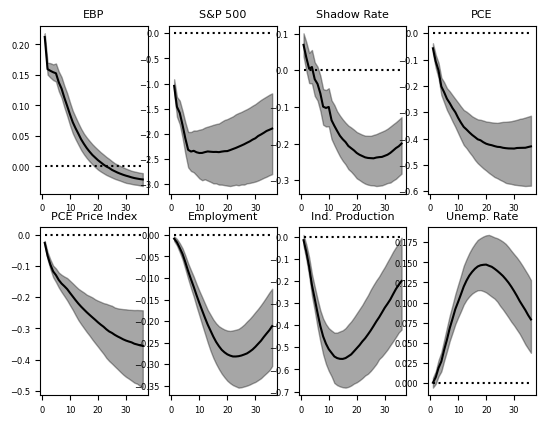

In [6]:
# Plots
quantiles = def_quantiles(outs, bands)
figure, axis = plt.subplots(2,math.ceil(nvar/2))
for w in range(nshocks):
    qtemp = quantiles[:,w,:,:]
    for i in range(nvar):
        if i < math.ceil(nvar/2):
            axis[0,i].plot(np.arange(1, nimp+1), np.zeros(nimp), color='black', linestyle='dotted')
            axis[0,i].fill_between(np.arange(1, nimp+1), qtemp[1,:,i], qtemp[2,:,i], alpha=0.35, color='black')
            axis[0,i].plot(np.arange(1, nimp+1), qtemp[0,:,i], color='black')
            axis[0,i].set_title(Yname[i], fontsize=8)
            axis[0,i].tick_params(axis='both', which='major', labelsize=6)
            axis[0,i].tick_params(axis='both', which='minor', labelsize=6)
        else:
            axis[1,i-nvar].plot(np.arange(1, nimp+1), np.zeros(nimp), color='black', linestyle='dotted')
            axis[1,i-nvar].fill_between(np.arange(1, nimp+1), qtemp[1,:,i], qtemp[2,:,i], alpha=0.35, color='black')
            axis[1,i-nvar].plot(np.arange(1, nimp+1), qtemp[0,:,i], color='black')
            axis[1,i-nvar].set_title(Yname[i], fontsize=8)
            axis[1,i-nvar].tick_params(axis='both', which='major', labelsize=6)
            axis[1,i-nvar].tick_params(axis='both', which='minor', labelsize=6)
    if savefigures == 1:
        plt.savefig("shock_" + str(w).zfill(1) + ".pdf")